In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
import math
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from sklearn.metrics import r2_score

In [41]:
#Function to convert GPS time to milliseconds
#The base time is the RTC time in milliseconds that corresponds with the first GPS time stamp
def timeToMillis(time, RTC_millis):
    sec = np.zeros(time.size)
    sec = sec.astype(int)
    minutes = np.zeros(time.size)
    minutes = minutes.astype(int)
    hours = np.zeros(time.size)
    hours = hours.astype(int)
    for i in range(0, time.size):
        sec[i] = time[i]%100
    for i in range(0, time.size):
        minutes[i] = (time[i]%10000 - time[i]%100)/100
    for i in range(0, time.size):
        hours[i] = (time[i] - time[i]%10000)/10000

    GPS_millis = np.zeros(time.size)
    GPS_millis = GPS_millis.astype(int)
    GPS_millis[0] = RTC_millis[0]
    for i in range (1, time.size):
        if (sec[i] > sec[i - 1]):
            if (minutes[i] >= minutes[i - 1]):
                GPS_millis[i] = GPS_millis[i - 1] + (sec[i] - sec[i - 1])*1000 + (minutes[i] - minutes[i - 1])*60*1000
            else:
                GPS_millis[i] = GPS_millis[i - 1] + (sec[i] - sec[i - 1])*1000 + (60 + minutes[i] - minutes[i - 1])*60*1000            
        else:
            if (minutes[i] >= minutes[i - 1]):
                GPS_millis[i] = GPS_millis[i - 1] + (60 + sec[i] - sec[i - 1])*1000 + (minutes[i] - minutes[i - 1] - 1)*60*1000
            else:
                GPS_millis[i] = GPS_millis[i - 1] + (60 + sec[i] - sec[i - 1])*1000 + (59 + minutes[i] - minutes[i - 1])*60*1000            
    return GPS_millis


#Function to convert time in milliseconds to digital time 
#Used to convert both GPS time in milliseconds and RTC time in milliseconds to digital time 
#The base time is taken as the first GPS time stamp
def millisToTime(millis, time):
    mil = millis/1000
    time_temp = np.zeros(time.size)
    hours = np.zeros(time_temp.size)
    minutes = np.zeros(time_temp.size)
    seconds = np.zeros(time_temp.size)
    time_temp[0] = time[0]
    for i in range (1, time.size):
        seconds[i] = time_temp[i - 1]%100 + (mil[i] - mil[i - 1])
        if (seconds[i] > 60):
            temp_minutes = 0
            while (seconds[i] >= 60):
                temp_minutes += 100
                seconds[i] = seconds[i] - 60
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100) + temp_minutes
        elif (seconds[i] == 60):
            seconds[i] = 0
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100) + 100
        else:
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100)
        if (minutes[i] > 5900):
            minutes[i] = 6000 - minutes[i]
            hours[i] = (time_temp[i-1] - time_temp[i-1]%10000) + 10000
        else:
            hours[i] = (time_temp[i-1] - time_temp[i-1]%10000)
        if (hours[i] > 230000):
            hours[i] = 240000 - hours[i]
        time_temp[i] = hours[i] + minutes[i] + seconds[i]

    #Split time with colons
    output_time = [0 for i in range(time_temp.size)]
    hours_temp = np.zeros(time_temp.size)
    minutes_temp = np.zeros(time_temp.size)
    seconds_temp = np.zeros(time_temp.size)
    for i in range (0, time_temp.size):
        hours_temp[i] = int((time_temp[i] - time_temp[i]%10000)/10000)
        minutes_temp[i] = int((time_temp[i]%10000 - time_temp[i]%100)/100)
        seconds_temp[i] = time_temp[i]%100
        if (seconds_temp[i] < 10):
            if(minutes_temp[i] < 10):
                output_time[i] = "%d:0%d:0%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
            else:
                output_time[i] = "%d:%d:0%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
        else:
            if(minutes_temp[i] < 10):
                output_time[i] = "%d:0%d:%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])  
            else:
                output_time[i] = "%d:%d:%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
    return output_time 

#Split data into training and testing sets (0.8/0.2)
def dataSplit(x_millis, y_millis):
    x_train, x_test, y_train, y_test = train_test_split(x_millis, y_millis, test_size=0.2, random_state=1)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 1)
    return x_train.reshape(-1,1), y_train.reshape(-1,1), x_test.reshape(-1,1), y_test.reshape(-1,1), x_val.reshape(-1,1), y_val.reshape(-1,1)


#Metrics for regression analysis
def RMSE(predict, y):
    c = np.zeros(predict.size)
    for i in range (0, predict.size):
        c[i] = (y[i] - predict[i])**2
    return np.sqrt((np.sum(c))/len(c))

def MAE(predict, y):
    c = np.zeros(predict.size)
    for i in range (0, predict.size):
        c[i] = abs(y[i] - predict[i])
    return (np.sum(c))/len(c)

#Metrics related to clock offset 
def plotDrift(GPS_millis, RTC_millis):
    Drift = np.zeros(GPS_millis.size)
    for i in range(1, GPS_millis.size):
        Drift[i] = ((GPS_millis[i] - RTC_millis[i])/GPS_millis[i])*1000000
    t = np.linspace(50000, len(GPS_millis[50000:len(GPS_millis)]), len(GPS_millis[50000:len(GPS_millis)]))
    plt.plot(t, Drift[50000:len(GPS_millis)])
    plt.title('Frequency of clock drift of Teensy internal RTC (ppm)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Drift (ppm)')
    plt.show()

def plotOffset(GPS_millis, RTC_millis):
    offset = np.zeros(GPS_millis.size)
    offsetsum = 0
    for i in range(0, GPS_millis.size):
        offset[i] = (GPS_millis[i] - offsetsum - RTC_millis[i])
        offsetsum = np.sum(offset)
    t = np.linspace(50000, len(GPS_millis[:50500]), len(GPS_millis[50000:50500]))
    plt.plot(t, offset[50000:50500])
    plt.title('Clock offset of internal Teensy RTC (ms)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Clock offset (ms)')
    plt.show()
    

def plotAccOffset(GPS_millis, RTC_millis):
    AccOffset = np.zeros(GPS_millis.size)
    for i in range(0, GPS_millis.size):
        AccOffset[i] = (GPS_millis[i] - RTC_millis[i])
    t = np.linspace(0, len(GPS_millis), len(GPS_millis))
    plt.plot(t, AccOffset)
    plt.title('Accumulated offset of Teensy internal RTC (ms)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Accumulated offset (ms)')
    plt.show()
    
def AccOffset(GPS_millis, RTC_millis):
    d = np.zeros(GPS_millis.size)
    for i in range(0, GPS_millis.size):
        d[i] = (GPS_millis[i] - RTC_millis[i])
    return d

def Drift(GPS_millis, RTC_millis):
    Drift = np.zeros(GPS_millis.size)
    for i in range(1, GPS_millis.size):
        Drift[i] = ((GPS_millis[i] - RTC_millis[i])/GPS_millis[i])*1000000
    return Drift


#dataframe to summarise linear regression metrics
def RegMetrics(x1_train, y1_train, x1_val, y1_val, x1_test, y1_test, model):
    predict1 = model.predict(x1_train)
    r1 =  model.score(x1_train, y1_train)
    rmse1 = RMSE(predict1, y1_train)
    mae1 =  MAE(predict1, y1_train)
    
    predict2 = model.predict(x1_test)
    r2 = model.score(x1_test, y1_test)
    rmse2 = RMSE(predict2, y1_test)
    mae2 = MAE(predict2, y1_test)
    
    predict3 = model.predict(x1_val)
    r3 = model.score(x1_val, y1_val)
    rmse3 = RMSE(predict3, y1_val)
    mae3 = MAE(predict3, y1_val)
    
    d = {'Index Title': ['Training', 'Validation', 'Test'],'R': [r1, r3, r2], 'RMSE' : [rmse1, rmse3, rmse2], 'MAE' :[mae1, mae3, mae2]}
    df = pd.DataFrame(d).set_index('Index Title')
    return display(df)


#Data Frames to summarise metrics for testing sets and display synchronised time
def synch(RTC_millis, GPS_millis, model, time, AccOffset):
    millis_predict = model.predict(RTC_millis.reshape(-1, 1))
    #Convert AccOffset prediction to synchronised time by adding the AccOffset to RTC time in milliseconds
    for i in range (0, millis_predict.size):
        millis_predict[i] = RTC_millis[i] + millis_predict[i]
    millis_predict = (np.reshape(millis_predict, len(millis_predict))).astype(int)
    r =  model.score(RTC_millis.reshape(-1, 1), AccOffset.reshape(-1, 1))
    rmse =  RMSE(millis_predict, GPS_millis)
    mae = MAE(millis_predict, GPS_millis)
    
    d = {'R': [r], 'RMSE' : [rmse], 'MAE' :[mae]}
    d = pd.DataFrame(d)
    display(d)
    df = pd.DataFrame({'GPS Time (ms)': GPS_millis, 'RTC Time (ms)': RTC_millis, 
                         'Synch Time (ms)' : millis_predict, 'GPS Time': millisToTime(GPS_millis, time),
                           'RTC Time':millisToTime(RTC_millis, time), 'Synch Time' : millisToTime(millis_predict, time)})
    return display(df)

In [85]:
#Reading data from training run of sensor node
with open('DS3231.TXT', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(",") for line in stripped if line)
    with open('DS3231.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('GPS/RTC', 'Time', 'Day', 'Month', 'Year', 'Millis', 'Temp', 'Offset', 'Number'))
        writer.writerows(lines)
        
data1 = pd.read_csv("DS3231.csv")
data_arr1 = np.array(data1)
time1 = data_arr1[0:,1]
#RTC_millis1 = data_arr1[0:,5]
temp1 = data_arr1[0:,6]
offset1 = data_arr1[0:,7]
num1 = data_arr1[0:,8]

RTC_millis1 = np.zeros(offset1.size)
for i in range(0, offset1.size):
    RTC_millis1[i] = offset1[i] + RTC_millis1[i - 1]
for i in range(0, offset1.size):
    RTC_millis1[i] = (RTC_millis1[i]/32768)*1000

#Reading data from training run of sensor node 
with open('DS32312.TXT', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(",") for line in stripped if line)
    with open('DS32312.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('GPS/RTC', 'Time', 'Day', 'Month', 'Year', 'Millis', 'Temp', 'Offset', 'Number'))
        writer.writerows(lines)
        
data2 = pd.read_csv("DS32312.csv")
data_arr2 = np.array(data2)
time2 = data_arr2[0:,1]
#RTC_millis1 = data_arr1[0:,5]
temp2 = data_arr2[0:,6]
offset2 = data_arr2[0:,7]
num2 = data_arr2[0:,8]

RTC_millis2 = np.zeros(offset2.size)
for i in range(0, offset2.size):
    RTC_millis2[i] = offset2[i] + RTC_millis2[i - 1]
for i in range(0, offset2.size):
    RTC_millis2[i] = (RTC_millis2[i]/32768)*1000

In [86]:
#Determining the GPS milliseconds since start-up for all three sensors
GPS_millis1 = timeToMillis(time1, RTC_millis1)

#Determining the AccOffset of all three sensors
AccOffset1 = AccOffset(GPS_millis1, RTC_millis1)

#Splitting the training and testing data only for the first sensor (on which the model is built and tested)
x1_train, y1_train, x1_test, y1_test, x1_val, y1_val = dataSplit(RTC_millis1, AccOffset1)

#Determining the GPS milliseconds since start-up for all three sensors
GPS_millis2 = timeToMillis(time2, RTC_millis2)

#Determining the AccOffset of all three sensors
AccOffset2 = AccOffset(GPS_millis2, RTC_millis2)

#Splitting the training and testing data only for the first sensor (on which the model is built and tested)
x2_train, y2_train, x2_test, y2_test, x2_val, y2_val = dataSplit(RTC_millis2, AccOffset2)

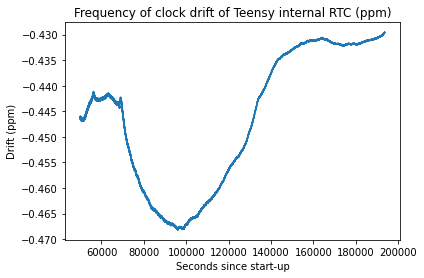

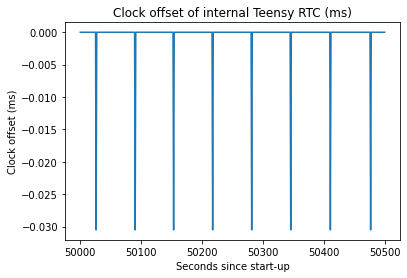

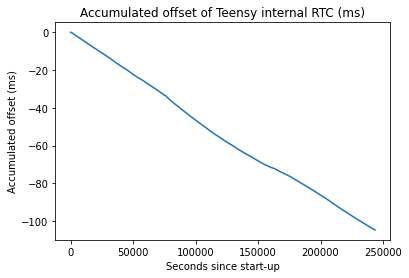

In [44]:
plotDrift(GPS_millis1, RTC_millis1)
plotOffset(GPS_millis1, RTC_millis1)
plotAccOffset(GPS_millis1, RTC_millis1)


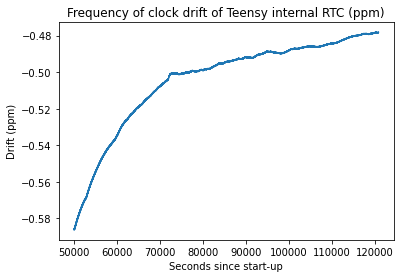

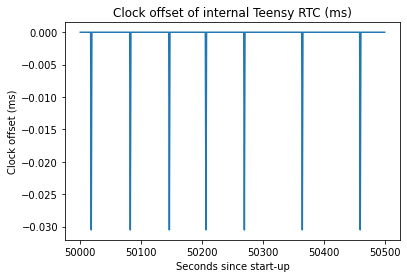

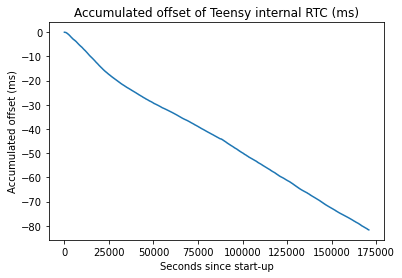

In [87]:
#Drift and AccOffset graphs of all three sensor sets
plotDrift(GPS_millis2, RTC_millis2)
plotOffset(GPS_millis2, RTC_millis2)
plotAccOffset(GPS_millis2, RTC_millis2)


In [27]:
print('RMSE Testing Sensor One: ', RMSE(RTC_millis1, GPS_millis1))
print('MAE Testing Sensor One:', MAE(RTC_millis1, GPS_millis1))

RMSE Testing Sensor One:  61.89644991533858
MAE Testing Sensor One: 53.96434943066533


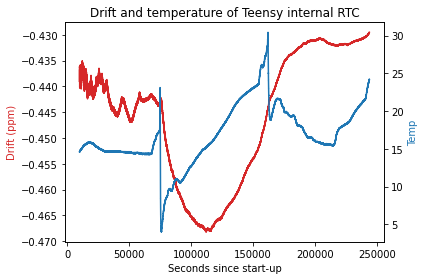

In [47]:
t = np.linspace(10000, len(GPS_millis1), len(GPS_millis1[10000:len(GPS_millis1)]))

fig, ax1 = plt.subplots()

color = 'tab:red'
drifty = np.zeros(GPS_millis1.size)
for i in range(1, GPS_millis1.size):
    drifty[i] = ((GPS_millis1[i] - RTC_millis1[i])/GPS_millis1[i])*1000000
ax1.plot(t, drifty[10000:len(GPS_millis1)], color = color)
ax1.set_xlabel('Seconds since start-up')
ax1.set_ylabel('Drift (ppm)', color = color)
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.plot(t, temp1[10000:len(GPS_millis1)], color = color)
ax2.set_ylabel('Temp', color = color)

plt.title('Drift and temperature of Teensy internal RTC')
fig.tight_layout()  
plt.show()

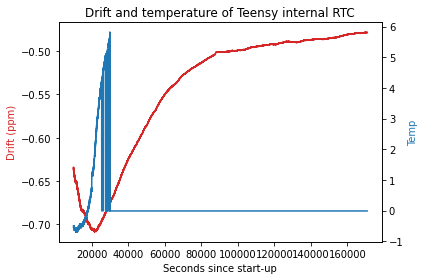

In [88]:
t = np.linspace(10000, len(GPS_millis2), len(GPS_millis2[10000:len(GPS_millis2)]))

fig, ax1 = plt.subplots()

color = 'tab:red'
drifty = np.zeros(GPS_millis2.size)
for i in range(1, GPS_millis2.size):
    drifty[i] = ((GPS_millis2[i] - RTC_millis2[i])/GPS_millis2[i])*1000000
ax1.plot(t, drifty[10000:len(GPS_millis2)], color = color)
ax1.set_xlabel('Seconds since start-up')
ax1.set_ylabel('Drift (ppm)', color = color)
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.plot(t, temp2[10000:len(GPS_millis2)], color = color)
ax2.set_ylabel('Temp', color = color)

plt.title('Drift and temperature of Teensy internal RTC')
fig.tight_layout()  
plt.show()

In [89]:
drift = Drift(GPS_millis1, RTC_millis1)
accOffset = AccOffset(GPS_millis1, RTC_millis1)

drift2 = Drift(GPS_millis2, RTC_millis2)
accOffset2 = AccOffset(GPS_millis2, RTC_millis2)

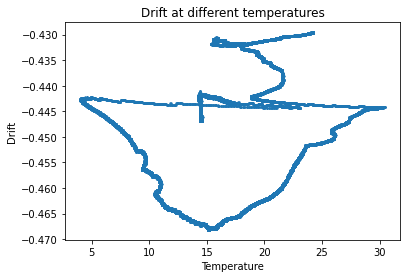

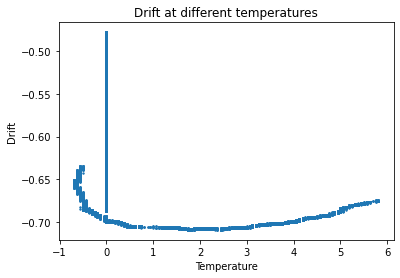

In [90]:
plt.scatter(temp1[50000:temp1.size], drift[50000:temp1.size], s = 2)
plt.title('Drift at different temperatures')
plt.xlabel('Temperature')
plt.ylabel('Drift')
plt.show()


plt.scatter(temp2[10000:drift2.size], drift2[10000:drift2.size], s = 2)
plt.title('Drift at different temperatures')
plt.xlabel('Temperature')
plt.ylabel('Drift')
plt.show()

In [103]:
#Drift and offset characteristics, training data 
print('Mean drift:', np.mean(drift))
print('Mean accumulated offset:', np.mean(accOffset))
print('Mean temperature:', np.mean(temp1))

print('Max drift:', np.min(drift))
print('Max accumulated offset:', np.min(accOffset))
print('Max temperature:', np.max(temp1))

Mean drift: -0.4438549580874125
Mean accumulated offset: -53.96434943066533
Mean temperature: 16.757160581494066
Max drift: -2.774325284090909
Max accumulated offset: -104.67529296875
Max temperature: 30.44


In [92]:
#Drift and offset characteristics, new data
print('Mean drift:', np.mean(drift2))
print('Mean accumulated offset:', np.mean(accOffset2))
print('Mean temperature:', np.mean(temp2))
print('Max drift:', np.min(drift2))
print('Max accumulated offset:', np.min(accOffset2))
print('Max temperature:', np.max(temp2))

Mean drift: -0.5395560783348555
Mean accumulated offset: -43.5312868855212
Mean temperature: 0.26584045934054656
Max drift: -0.7088227464360223
Max accumulated offset: -81.72607421875
Max temperature: 22.69


In [34]:
#Scikit learn Linear Regression
model1 = LinearRegression().fit(x1_train, y1_train)
print("Performance of model on training set")
RegMetrics(x1_train, y1_train, x1_val, y1_val, x1_test, y1_test, model1)
print("Synchronised time: Training set Sensor 1")
synch(RTC_millis1, GPS_millis1, model1, time1, accOffset)
#synch.to_csv(r'C:\Users\suben\Documents\Priyanka\Skripsie\synch1.csv', index = False)

Performance of model on training set


,R,RMSE,MAE
Index Title,,,
Training,0.997357,1.557791,1.394750
Validation,0.997359,1.563732,1.402502
Test,0.997348,1.560839,1.397835


Synchronised time: Training set Sensor 1


,R,RMSE,MAE
0,0.997356,1.659345,1.537668


,GPS Time (ms),RTC Time (ms),Synch Time (ms),GPS Time,RTC Time,Synch Time
0,1000,1.000000e+03,998,11:12:29.000,11:12:29.000,11:12:29.000
1,2000,2.000000e+03,1998,11:12:30.000,11:12:30.000,11:12:30.000
2,3000,3.000000e+03,2998,11:12:31.000,11:12:31.000,11:12:31.000
3,4000,4.000000e+03,3998,11:12:32.000,11:12:32.000,11:12:32.000
4,5000,5.000000e+03,4998,11:12:33.000,11:12:33.000,11:12:33.000
...,...,...,...,...,...,...
243647,243686000,2.436861e+08,243685998,6:53:54.000,6:53:54.105,6:53:54.000
243648,243687000,2.436871e+08,243686998,6:53:55.000,6:53:55.105,6:53:55.000
243649,243688000,2.436881e+08,243687998,6:53:56.000,6:53:56.105,6:53:56.000
243650,243689000,2.436891e+08,243688998,6:53:57.000,6:53:57.105,6:53:57.000


In [35]:
net1 = MLPRegressor(alpha = 1e-4, solver = 'adam', random_state =1,
                  learning_rate_init = 0.1/(10)).fit(x1_train, np.reshape(y1_train, len(y1_train)))
print("Performance of model on training set")
RegMetrics(x1_train, y1_train, x1_val, y1_val, x1_test, y1_test, net1)
print("Synchronised time: Training set Sensor 1")
synch(RTC_millis1, GPS_millis1, net1, time1, accOffset)

Performance of model on training set


,R,RMSE,MAE
Index Title,,,
Training,0.996563,1.776462,1.430493
Validation,0.996574,1.781080,1.433885
Test,0.996546,1.781527,1.435063


Synchronised time: Training set Sensor 1


,R,RMSE,MAE
0,0.996562,1.773789,1.349732


,GPS Time (ms),RTC Time (ms),Synch Time (ms),GPS Time,RTC Time,Synch Time
0,1000,1.000000e+03,1000,11:12:29.000,11:12:29.000,11:12:29.000
1,2000,2.000000e+03,2000,11:12:30.000,11:12:30.000,11:12:30.000
2,3000,3.000000e+03,3000,11:12:31.000,11:12:31.000,11:12:31.000
3,4000,4.000000e+03,4000,11:12:32.000,11:12:32.000,11:12:32.000
4,5000,5.000000e+03,5000,11:12:33.000,11:12:33.000,11:12:33.000
...,...,...,...,...,...,...
243647,243686000,2.436861e+08,243685997,6:53:54.000,6:53:54.105,6:53:53.997
243648,243687000,2.436871e+08,243686997,6:53:55.000,6:53:55.105,6:53:54.997
243649,243688000,2.436881e+08,243687997,6:53:56.000,6:53:56.105,6:53:55.997
243650,243689000,2.436891e+08,243688997,6:53:57.000,6:53:57.105,6:53:56.997


In [11]:
error = np.zeros(6)
for i in range(1, 6):
    net1 = MLPRegressor(alpha = 1e-4, solver = 'adam', random_state =1,
                  learning_rate_init = 0.1/(10*i)).fit(x1_train, np.reshape(y1_train, len(y1_train)))
    predict = net1.predict(x1_val)
    error[i - 1] = RMSE(predict, y1_val)

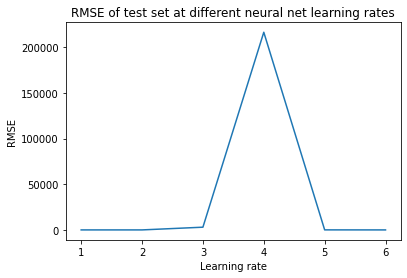

In [12]:
t = np.linspace(1, 6, 6)
plt.plot(t, error)
plt.title('RMSE of test set at different neural net learning rates')
plt.xlabel('Learning rate')
plt.ylabel('RMSE')
plt.show()

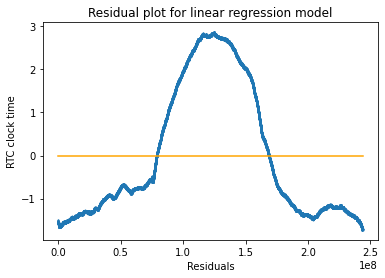

In [36]:
predict1 = model1.predict(x1_val)
resid1 = np.zeros(y1_val.size)
for i in range(y1_val.size):
    resid1[i] = predict1[i] - y1_val[i]
#Residual plots
t = np.linspace(0, max(x1_val))
z = np.zeros(50)
plt.scatter(x1_val, resid1, s = 1)
plt.plot(t, z, color = 'orange')
plt.title('Residual plot for linear regression model')
plt.xlabel('Residuals')
plt.ylabel('RTC clock time')
plt.show()

In [15]:
#TensorFlow linear regression training and validation
normalizer1 = preprocessing.Normalization()
normalizer1.adapt(x1_train)

model3 = tf.keras.Sequential([
    normalizer1,
    layers.Dense(units=1)
])

model3.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history1 = model3.fit(
    np.reshape(x1_train, len(x1_train)).astype(float), np.reshape(y1_train, len(y1_train)).astype(float),
    epochs = 8,
    verbose = 1
    )

Train on 194921 samples
Epoch 1/8
194921/194921 [==============================] - 6s 30us/sample - loss: 4.1554
Epoch 2/8
194921/194921 [==============================] - 6s 29us/sample - loss: 1.82682s - - ETA: 1s - loss: 1 - ETA: 1s - loss: 1.8  - ETA: 0s - loss: 1.
Epoch 3/8
194921/194921 [==============================] - 6s 29us/sample - loss: 1.8271
Epoch 4/8
194921/194921 [==============================] - 6s 30us/sample - loss: 1.8264
Epoch 5/8
194921/194921 [==============================] - 6s 29us/sample - loss: 1.8266
Epoch 6/8
194921/194921 [==============================] - 6s 31us/sample - loss: 1.82584s -  - ETA: 4s - loss: 1.820
Epoch 7/8
194921/194921 [==============================] - 6s 30us/sample - loss: 1.82711s - loss: 1.82 - ETA: 1s - ETA: 0s -
Epoch 8/8
194921/194921 [==============================] - 6s 32us/sample - loss: 1.8270


In [48]:
error = np.zeros(8)
for i in range(1, 9):
    history1 = model3.fit( 
    np.reshape(x1_train, len(x1_train)).astype(float), np.reshape(y1_train, len(y1_train)).astype(float),
    epochs = i,
    verbose = 1
    )
    predict = model3.predict(x1_val)
    error[i - 1] = RMSE(predict, y1_val)

Train on 194921 samples
194921/194921 [==============================] - 7s 36us/sample - loss: 1.2412
Train on 194921 samples
Epoch 1/2
194921/194921 [==============================] - 7s 34us/sample - loss: 1.2405
Epoch 2/2
194921/194921 [==============================] - 8s 39us/sample - loss: 1.2399
Train on 194921 samples
Epoch 1/3
194921/194921 [==============================] - 6s 30us/sample - loss: 1.2411
Epoch 2/3
194921/194921 [==============================] - 6s 30us/sample - loss: 1.24030s - loss: 
Epoch 3/3
194921/194921 [==============================] - 6s 31us/sample - loss: 1.2403 1s - los - ET
Train on 194921 samples
Epoch 1/4
194921/194921 [==============================] - 6s 31us/sample - loss: 1.24075s - loss: 1 - E - ETA: 0s - loss: 1.240
Epoch 2/4
194921/194921 [==============================] - 6s 31us/sample - loss: 1.2412
Epoch 3/4
194921/194921 [==============================] - 7s 33us/sample - loss: 1.2404- ETA: 0s - loss
Epoch 4/4
194921/194921 [=======

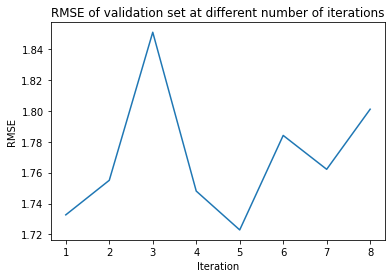

[1.73267291 1.75503904 1.85088225 1.74807051 1.72292063 1.78408383
 1.76215936 1.80105834]


In [49]:
t = np.linspace(1, 8, 8)
plt.plot(t, error)
plt.title('RMSE of validation set at different number of iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.show()
print(error)

In [50]:
history1 = model3.fit(
    np.reshape(x1_train, len(x1_train)).astype(float), np.reshape(y1_train, len(y1_train)).astype(float),
    epochs = 5,
    verbose = 1
    )

Train on 194921 samples
Epoch 1/5
194921/194921 [==============================] - 6s 29us/sample - loss: 1.24063 - ETA: 2s - loss: 1.24 - ETA: 2s - loss: 1. - ETA: 2s - l - ETA: 2s - loss: 1.2 - ETA: 1s 
Epoch 2/5
194921/194921 [==============================] - ETA: 0s - loss: 1.2405- ETA: 5s - loss: 1. - ETA: 5s - loss: 1.260 - ETA: 5s - ETA: 4s - loss: 1.2 - ETA: 4s - loss: 1.24 - ETA: 3s - l - 6s 30us/sample - loss: 1.2406
Epoch 3/5
194921/194921 [==============================] - 6s 29us/sample - loss: 1.24045s - loss:  - ETA: 4s -  - ETA: 0s - loss
Epoch 4/5
194921/194921 [==============================] - 6s 29us/sample - loss: 1.2406 ETA: 1s - l - ETA: 0s - lo
Epoch 5/5
194921/194921 [==============================] - 6s 29us/sample - loss: 1.24072s - ETA: 0s


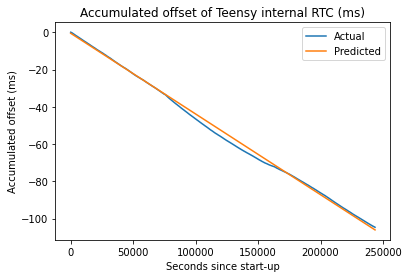

In [51]:
#Predicted vs actual, linear regression, training data 
prediction = model3.predict(RTC_millis1)
stuff1 = np.zeros(GPS_millis1.size)
for i in range(0, GPS_millis1.size):
    stuff1[i] = (GPS_millis1[i] - RTC_millis1[i])
t = np.linspace(0, len(GPS_millis1), len(GPS_millis1))
plt.plot(t, stuff1, label = 'Actual')
plt.plot(t, prediction, label = 'Predicted')
plt.title('Accumulated offset of Teensy internal RTC (ms)')
plt.xlabel('Seconds since start-up')
plt.ylabel('Accumulated offset (ms)')
plt.legend()
plt.show()

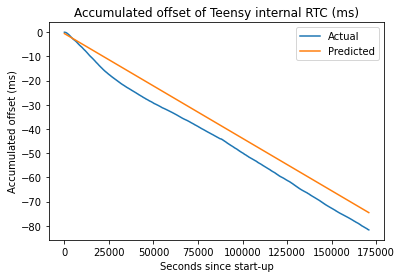

In [93]:
#Predicted vs actual, linear model, new data 
pred = model3.predict(RTC_millis2)
st = np.zeros(GPS_millis2.size)
for i in range(0, GPS_millis2.size):
    st[i] = (GPS_millis2[i] - RTC_millis2[i])
t = np.linspace(0, len(GPS_millis2), len(GPS_millis2))
plt.plot(t, st, label = 'Actual')
plt.plot(t, pred, label = 'Predicted')
plt.title('Accumulated offset of Teensy internal RTC (ms)')
plt.xlabel('Seconds since start-up')
plt.ylabel('Accumulated offset (ms)')
plt.legend()
plt.show()

In [96]:
#Metrics for linear regression
predict = model3.predict(np.reshape(x1_train, len(x1_train)).astype(float))
predict = np.reshape((predict),len(predict))
print(MAE(predict, y1_train))
print(RMSE(predict, y1_train))

predict = model3.predict(np.reshape(x1_val, len(x1_val)).astype(float))
predict = np.reshape((predict),len(predict))
print(MAE(predict, y1_val))
print(RMSE(predict, y1_val))

predict = model3.predict(np.reshape(x1_test, len(x1_test)).astype(float))
predict = np.reshape((predict),len(predict))
print(MAE(predict, y1_test))
print(RMSE(predict, y1_test))

predict = model3.predict(np.reshape(RTC_millis2, len(RTC_millis2)).astype(float))
predict = np.reshape((predict),len(predict))
print(MAE(predict, accOffset2))
print(RMSE(predict, accOffset2))
r2_score(accOffset2, predict)

1.261972091920375
1.6948144228388178
1.2659336467408655
1.69935060746787
1.268714904706877
1.7003844719051602
5.998035028903999
6.221449038033256


0.9231743522599148

In [53]:
#Tensor flow neural network training and validation
def build_and_compile_model(norm,i):
  model = keras.Sequential([
      norm,
      layers.Dense(40, activation='relu'),
      layers.Dense(40, activation='relu'),
      layers.Dense(40, activation='relu'),
      layers.Dense(40, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.1/(10**i)))
  return model

#net2 = build_and_compile_model(normalizer1)

#history2 = net2.fit(
#    np.reshape(x1_train, len(x1_train)).astype(float), np.reshape(y1_train, len(y1_train)).astype(float),
#    verbose=1, epochs=8)

In [54]:
error1 = np.zeros(8)
for i in range(1, 9):
    history2 = net2.fit(
    np.reshape(x1_train, len(x1_train)).astype(float), np.reshape(y1_train, len(y1_train)).astype(float),
    verbose=1, epochs=i)
    predict1 = net2.predict(x1_val)
    error1[i - 1] = RMSE(predict1, y1_val)

Train on 194921 samples
194921/194921 [==============================] - 7s 35us/sample - loss: 0.09606s - loss - ETA: - ETA: 4s - loss:  - ETA - ETA: 3s - loss: 0 - ET - ETA: 0s -  - ETA: 0s - loss: 
Train on 194921 samples
Epoch 1/2
194921/194921 [==============================] - 7s 35us/sample - loss: 0.08166s - loss - ETA: 5s - loss: 0.084 - ETA: 5s - loss: 0.08 -  - ETA: 3s - lo
Epoch 2/2
194921/194921 [==============================] - 7s 36us/sample - loss: 0.0788
Train on 194921 samples
Epoch 1/3
194921/194921 [==============================] - 7s 35us/sample - loss: 0.07483s - - ETA - ETA: 1s - loss: 0. - ETA:  - ETA: 0s -
Epoch 2/3
194921/194921 [==============================] - 7s 35us/sample - loss: 0.07364s - ETA: 2s - loss - - ETA: 0s - loss: 0.073 - ETA: 0
Epoch 3/3
194921/194921 [==============================] - 7s 36us/sample - loss: 0.0697
Train on 194921 samples
Epoch 1/4
194921/194921 [==============================] - 8s 39us/sample - loss: 0.0683
Epoch 2/4
1949

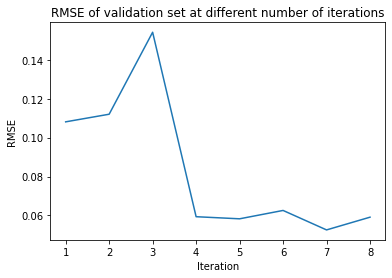

[0.10811476 0.11203033 0.15418354 0.05933453 0.05825488 0.06255401
 0.05254237 0.05909281]


In [55]:
t = np.linspace(1, 8, 8)
plt.plot(t, error1)
plt.title('RMSE of validation set at different number of iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.show()
print(error1)

In [56]:
error2 = np.zeros(8)
for i in range(1, 9):
    net2 = build_and_compile_model(normalizer1, i)
    history2 = net2.fit(
    np.reshape(x1_train, len(x1_train)).astype(float), np.reshape(y1_train, len(y1_train)).astype(float),
    verbose=1, epochs=7)
    predict2 = net2.predict(x1_val)
    error2[i - 1] = RMSE(predict2, y1_val)

Train on 194921 samples
Epoch 1/7
194921/194921 [==============================] - 8s 40us/sample - loss: 1.085712s - loss: 3.75 - ETA: 11s -  - ET - ETA: 0s - l
Epoch 2/7
194921/194921 [==============================] - ETA: 0s - loss: 0.6527- ETA: 3s - l - ETA: 3s - loss: 0.67 - ETA: 3s - l - ETA: 0s - loss: 0.6 - 7s 38us/sample - loss: 0.6536
Epoch 3/7
194921/194921 [==============================] - 8s 39us/sample - loss: 0.58035s - loss: 0.62 - ETA: - ETA: 4 - 
Epoch 4/7
194921/194921 [==============================] - 8s 39us/sample - loss: 0.48933s - loss - ETA: 3s - - ETA: 2s - loss: 0 - ETA: 2s - loss: 0.5 - ETA: 2s - loss: - ETA: 2s - los - ETA: 0s - los
Epoch 5/7
194921/194921 [==============================] - 8s 41us/sample - loss: 0.4527
Epoch 6/7
194921/194921 [==============================] - 8s 41us/sample - loss: 0.41514s - - ETA: 2s - loss: 0.422 - ETA: 2s - - E - ETA: 0s - l - ETA: 0s - loss: 
Epoch 7/7
194921/194921 [==============================] - 8s 41us/sampl

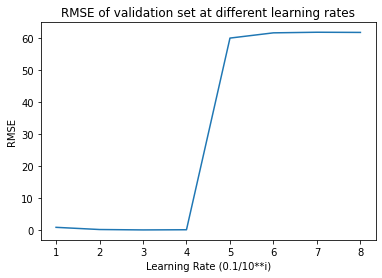

[ 0.87133285  0.18797903  0.06477801  0.11801673 59.89910655 61.53508519
 61.72182932 61.66747268]


In [57]:
t = np.linspace(1,8,8)
plt.plot(t, error2)
plt.title('RMSE of validation set at different learning rates')
plt.xlabel('Learning Rate (0.1/10**i)')
plt.ylabel('RMSE')
plt.show()
print(error2)

In [58]:
net2 = build_and_compile_model(normalizer1,2)

history2 = net2.fit(
    np.reshape(x1_train, len(x1_train)).astype(float), np.reshape(y1_train, len(y1_train)).astype(float),
    verbose=1, epochs=7)

Train on 194921 samples
Epoch 1/7
194921/194921 [==============================] - 8s 39us/sample - loss: 1.0209 ETA: 2s - loss: 1.330 - ETA: 1 - ET
Epoch 2/7
194921/194921 [==============================] - 7s 37us/sample - loss: 0.13036s - loss: 0 - ETA: 6s - los  - ET - ETA: 3s  - ETA: 2s - loss: - ETA: 1s - loss: 0.1 - ETA: 1s - loss: 0.132 - ETA: 0s - l - ETA: 0s - los
Epoch 3/7
194921/194921 [==============================] - 7s 37us/sample - loss: 0.12843s - ETA: 2s - loss: 0.  - ETA:
Epoch 4/7
194921/194921 [==============================] - 7s 38us/sample - loss: 0.1279 -  - ETA: 1s - loss: 0 - ETA: 1s - loss - ET
Epoch 5/7
194921/194921 [==============================] - 8s 39us/sample - loss: 0.1242
Epoch 6/7
194921/194921 [==============================] - 8s 43us/sample - loss: 0.12911s - loss:  - ETA: 1s - loss - ETA: 0s - loss: 0 - ETA: 0s - l
Epoch 7/7
194921/194921 [==============================] - 8s 41us/sample - loss: 0.12176s - loss: 0.1 - ETA: 6s - loss: 0. - ETA

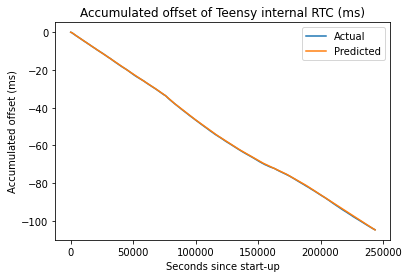

In [59]:
#Predicted vs actual, neural network, training data
prediction2 = net2.predict(RTC_millis1)
stuff2 = np.zeros(GPS_millis1.size)
for i in range(0, GPS_millis1.size):
    stuff2[i] = (GPS_millis1[i] - RTC_millis1[i])
t = np.linspace(0, len(GPS_millis1), len(GPS_millis1))
plt.plot(t, stuff2, label = 'Actual')
plt.plot(t, prediction2, label = 'Predicted')
plt.title('Accumulated offset of Teensy internal RTC (ms)')
plt.xlabel('Seconds since start-up')
plt.ylabel('Accumulated offset (ms)')
plt.legend()
plt.show()

4.826401335496694
5.145747015117941


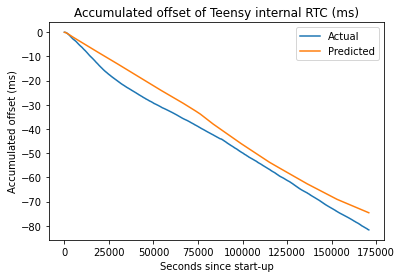

In [97]:
#Predicted vs actual offset, neural network, new data
predict4 = net2.predict((RTC_millis2).astype(float))
predict4 = np.reshape((predict4),len(predict4))
print(MAE(predict4, accOffset2))
print(RMSE(predict4, accOffset2))

prediction3 = net2.predict(RTC_millis2)
stuff3 = np.zeros(GPS_millis2.size)
for i in range(0, GPS_millis2.size):
    stuff3[i] = (GPS_millis2[i] - RTC_millis2[i])
t = np.linspace(0, len(GPS_millis2), len(GPS_millis2))
plt.plot(t, stuff3, label = 'Actual')
plt.plot(t, prediction3, label = 'Predicted')
plt.title('Accumulated offset of Teensy internal RTC (ms)')
plt.xlabel('Seconds since start-up')
plt.ylabel('Accumulated offset (ms)')
plt.legend()
plt.show()

In [98]:
#Metrics on neural network
predict = net2.predict((x1_train).astype(float))
predict = np.reshape((predict),len(predict))
print(MAE(predict, y1_train))
print(RMSE(predict, y1_train))

predict2 = net2.predict((x1_val).astype(float))
predict2 = np.reshape((predict2),len(predict2))
print(MAE(predict2, y1_val))
print(RMSE(predict2, y1_val))

predict = net2.predict((x1_test).astype(float))
predict = np.reshape((predict),len(predict))
print(MAE(predict, y1_test))
print(RMSE(predict, y1_test))

predict4 = net2.predict((RTC_millis2).astype(float))
predict4 = np.reshape((predict4),len(predict4))
print(MAE(predict4, AccOffset2))
print(RMSE(predict4, AccOffset2))
r2_score(accOffset2, predict4)


0.14539786745824404
0.17389745654902497
0.1443948669940472
0.17288037827450584
0.14527990793708234
0.1740627393436009
4.826401335496694
5.145747015117941


0.9474442792773766

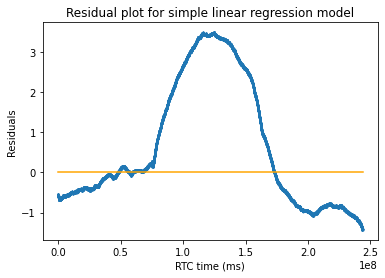

In [61]:
#Residuals, linear model, training data
predict2 = model3.predict(x1_val)
resid2 = np.zeros(y1_val.size)
for i in range(y1_val.size):
    resid2[i] = predict2[i] - y1_val[i]
#Residual plots
t = np.linspace(0, max(x1_val))
z = np.zeros(50)
plt.scatter(x1_val, resid2, s = 1)
plt.plot(t, z, color = 'orange')
plt.title('Residual plot for simple linear regression model')
plt.xlabel('RTC time (ms)')
plt.ylabel('Residuals')
plt.show()

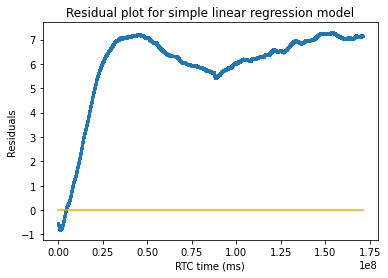

In [100]:
#Residuals, linear model, new data
pred1 = model3.predict(RTC_millis2)
res1 = np.zeros(accOffset2.size)
for i in range(accOffset2.size):
    res1[i] = pred1[i] - accOffset2[i]
#Residual plots
t = np.linspace(0, max(RTC_millis2))
z = np.zeros(50)
plt.scatter(RTC_millis2, res1, s = 1)
plt.plot(t, z, color = 'orange')
plt.title('Residual plot for simple linear regression model')
plt.xlabel('RTC time (ms)')
plt.ylabel('Residuals')
plt.show()

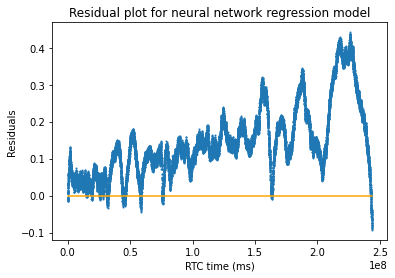

In [62]:
#Residuals, neural network, original data 
predict1 = net2.predict(x1_val)
resid1 = np.zeros(y1_val.size)
for i in range(y1_val.size):
    resid1[i] = predict1[i] - y1_val[i]
#Residual plots
t = np.linspace(0, max(x1_val))
z = np.zeros(50)
plt.scatter(x1_val, resid1, s = 1)
plt.plot(t, z, color = 'orange')
plt.title('Residual plot for neural network regression model')
plt.xlabel('RTC time (ms)')
plt.ylabel('Residuals')
plt.show()

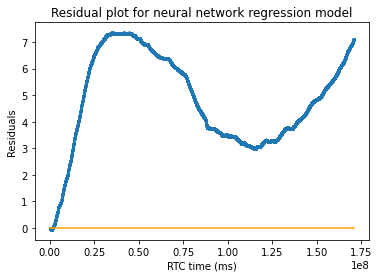

In [99]:
#Reisduals, neural network , new data 
pred2 = net2.predict(RTC_millis2)
res2 = np.zeros(accOffset2.size)
for i in range(accOffset2.size):
    res2[i] = pred2[i] - accOffset2[i]
#Residual plots
t = np.linspace(0, max(RTC_millis2))
z = np.zeros(50)
plt.scatter(RTC_millis2, res2, s = 1)
plt.plot(t, z, color = 'orange')
plt.title('Residual plot for neural network regression model')
plt.xlabel('RTC time (ms)')
plt.ylabel('Residuals')
plt.show()

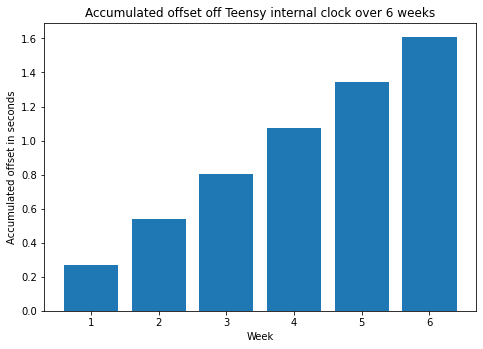

In [63]:
#plot of predicted accumulated offset over 6 weeks 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['1', '2', '3', '4', '5', '6']
students = [(0.444/1000000)*604800,(0.444/1000000)*604800*2,(0.444/1000000)*604800*3,(0.444/1000000)*604800*4,(0.444/1000000)*604800*5, (0.444/1000000)*604800*6]
ax.bar(langs,students)
plt.title('Accumulated offset off Teensy internal clock over 6 weeks')
plt.xlabel('Week')
plt.ylabel('Accumulated offset in seconds')
plt.show()

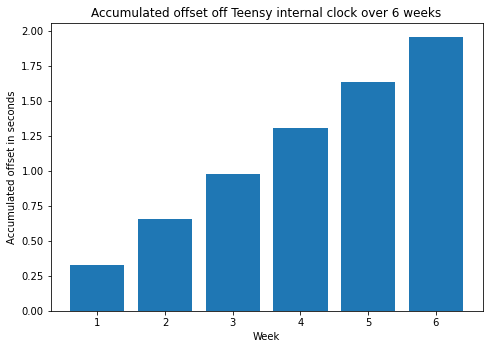

In [101]:
#Plot of predicted accumulated offset over 6 weeks
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['1', '2', '3', '4', '5', '6']
students = [(0.540/1000000)*604800,(0.540/1000000)*604800*2,(0.540/1000000)*604800*3,(0.540/1000000)*604800*4,(0.540/1000000)*604800*5, (0.540/1000000)*604800*6]
ax.bar(langs,students)
plt.title('Accumulated offset off Teensy internal clock over 6 weeks')
plt.xlabel('Week')
plt.ylabel('Accumulated offset in seconds')
plt.show()